# Using Data Mining Techniques into Real Estates Industry

**Author**:  _Madalina-Alina Racovita, 1st year master's student on **Computational Optimization at Faculty of Computer Science**, UAIC, Iasi, Romania_

<h1>Task 3 - Supervised Classification<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dependencies-&amp;-environment-configuration" data-toc-modified-id="Import-dependencies-&amp;-environment-configuration-1">Import dependencies &amp; environment configuration</a></span></li><li><span><a href="#Load-dataframes" data-toc-modified-id="Load-dataframes-2">Load dataframes</a></span></li><li><span><a href="#Preprocessing-steps" data-toc-modified-id="Preprocessing-steps-3">Preprocessing steps</a></span><ul class="toc-item"><li><span><a href="#Removing-constant-features" data-toc-modified-id="Removing-constant-features-3.1">Removing constant features</a></span></li><li><span><a href="#Replacing-the-missing-values" data-toc-modified-id="Replacing-the-missing-values-3.2">Replacing the missing values</a></span><ul class="toc-item"><li><span><a href="#Removing-columns-with-missing-percentage-$\ge$-0.95" data-toc-modified-id="Removing-columns-with-missing-percentage-$\ge$-0.95-3.2.1">Removing columns with missing percentage $\ge$ 0.95</a></span></li></ul></li><li><span><a href="#Boolean-type-to-numerical" data-toc-modified-id="Boolean-type-to-numerical-3.3">Boolean type to numerical</a></span></li><li><span><a href="#Dropping-corner-cases-observations" data-toc-modified-id="Dropping-corner-cases-observations-3.4">Dropping corner cases observations</a></span></li><li><span><a href="#Constructing-new-features" data-toc-modified-id="Constructing-new-features-3.5">Constructing new features</a></span></li></ul></li><li><span><a href="#Features-filtration" data-toc-modified-id="Features-filtration-4">Features filtration</a></span><ul class="toc-item"><li><span><a href="#Selecting-the-most-relevant-continuous-variables" data-toc-modified-id="Selecting-the-most-relevant-continuous-variables-4.1">Selecting the most relevant continuous variables</a></span></li><li><span><a href="#Correlation-between-categorical-features" data-toc-modified-id="Correlation-between-categorical-features-4.2">Correlation between categorical features</a></span></li><li><span><a href="#Analysing-Cramer's-V-values-between-isRCON-and-the-rest-of-the-nominal-predictors" data-toc-modified-id="Analysing-Cramer's-V-values-between-isRCON-and-the-rest-of-the-nominal-predictors-4.3">Analysing Cramer's V values between isRCON and the rest of the nominal predictors</a></span></li></ul></li><li><span><a href="#Data-encoding" data-toc-modified-id="Data-encoding-5">Data encoding</a></span></li><li><span><a href="#Decission-Trees-classification" data-toc-modified-id="Decission-Trees-classification-6">Decission Trees classification</a></span></li><li><span><a href="#K-Nearest-Neighbours" data-toc-modified-id="K-Nearest-Neighbours-7">K Nearest Neighbours</a></span><ul class="toc-item"><li><span><a href="#Comparison-between-1-NN-and-tunned-k" data-toc-modified-id="Comparison-between-1-NN-and-tunned-k-7.1">Comparison between 1-NN and tunned k</a></span></li></ul></li><li><span><a href="#Gaussian-Naive-Bayes" data-toc-modified-id="Gaussian-Naive-Bayes-8">Gaussian Naive Bayes</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9">References</a></span></li></ul></div>

## Import dependencies & environment configuration

In [72]:
!pip install researchpy
!pip install pydotplus

In [2]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
import researchpy as rp
import pydotplus

from scipy.stats import chi2_contingency
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

C:\tools\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Load dataframes

The dataframes are going to be loaded in an unprocessed version since, for this task the feature selection has to be made using empirical and encapsulated manners. It is specified the fact that the features **UnitsInBuilding** and **Stories** are going to be removed from the dataframe, the classification task is going to be pursued only of the real estates geographically localized in the **Washington state**.

In [3]:
os.listdir('./../Data')

['RCON_12011.assessor.tsv',
 'RCON_53033.assessor.tsv',
 'RSFR_12011.assessor.tsv',
 'RSFR_53033.assessor.tsv']

In [4]:
df_rcon = pd.concat([pd.read_csv("./../Data/RCON_12011.assessor.tsv", sep = "\t"), 
                     pd.read_csv("./../Data/RCON_53033.assessor.tsv", sep = "\t")])
df_rsfr = pd.concat([pd.read_csv("./../Data/RSFR_12011.assessor.tsv", sep = "\t"), 
                     pd.read_csv("./../Data/RSFR_53033.assessor.tsv", sep = "\t")])

df_rcon['isRCON'] = 1
df_rsfr['isRCON'] = 0

df = pd.concat([df_rcon, df_rsfr])

In [5]:
del df['UnitsInBuilding']
del df['Stories']

In [6]:
df = df[df['State'] == 'WA']

## Preprocessing steps

### Removing constant features

In [7]:
columns_constant_features = ['AtticSqft', 'IsFixer', 'GarageNoOfCars', 'EffectiveYearBuilt', 'TotalRooms', 'State']
for current in columns_constant_features:
    del df[current]

### Replacing the missing values

#### Removing columns with missing percentage $\ge$ 0.95

In [8]:
column_miss_perc_ge_95 = ['DeedType', 'RoofCode', 'BuildingShapeCode', 'City', 'StructureCode']
for column in column_miss_perc_ge_95:
    del df[column]

In [9]:
features_with_missing_values = ['BuildingCode', 'GarageCarportCode', 'PatioPorchCode', 'PoolCode', 'Zonning', \
                                'PropTaxAmount', 'FoundationCode', 'ExteriorCode', 'CoolingCode', 'HeatingCode', \
                                'HeatingSourceCode', 'View', 'DocType', 'TransType', 'DistressCode', 'SellPrice']

In [10]:
object_miss_values_features = []
numeric_miss_values_features = []
types = df[features_with_missing_values].dtypes

for i in range(len(types)):
    if types[i] == object:
        object_miss_values_features.append(features_with_missing_values[i])
    else:
        numeric_miss_values_features.append(features_with_missing_values[i])

for column in object_miss_values_features:
    df[column] = df[column].fillna('')
    
rcon_medium_sellprice = df_rcon['SellPrice'].mean()
rsfr_medium_sellprice = df_rsfr['SellPrice'].mean()

for column in numeric_miss_values_features:
    if column != 'SellPrice':
        df[column] = df[column].fillna(0)
        
prices = []
for (index, row) in df.iterrows():
    added = False
    if pd.isnull(row['SellPrice']):
        row['SellPrice'] = row['LastSalePrice']
    if row['SellPrice'] == 0:
        if row['isRCON'] == 1:
            prices.append(rcon_medium_sellprice)
        else:
            prices.append(rsfr_medium_sellprice)
    elif row['SellPrice'] != 0:
        prices.append(row['SellPrice'])
        
df['SellPrice'] = prices   

df.loc[(df['isRCON'] == 1) & (df['LastSalePrice'] == 0), 'LastSalePrice'] = rcon_medium_sellprice
df.loc[(df['isRCON'] == 0) & (df['LastSalePrice'] == 0), 'LastSalePrice'] = rsfr_medium_sellprice

### Boolean type to numerical

In [11]:
bool_type_columns = df.select_dtypes(include=bool).columns.tolist()
for column in bool_type_columns:
    df[column] = df[column].apply(lambda x: 0 if x == False else 1)

In [12]:
df.head()

CountyFipsCode  BuildingCode  StructureNbr  LandSqft  LivingSqft  GarageSqft  BasementSqft  BasementFinishedSqft  Bedrooms  TotalBaths  FirePlaces  YearBuilt Condition  ConditionCode Quality  QualityCode GarageCarportCode  HasPatioPorch  PatioPorchCode  HasPool PoolCode  Zonning  LandValue  ImprovementValue  TotalValue  AssessedYear  PropTaxAmount    Zip  Latitude  Longitude  ConstructionCode  FoundationCode  ExteriorCode  CoolingCode HeatingCode  HeatingSourceCode  IsWaterfront  View  ViewScore         LastSaleDate  LastSalePrice DocType TransType  ArmsLengthFlag DistressCode           StatusDate    SellDate  SellPrice  OwnerOccupied  DistrsdProp  isRCON
0  53033           1.0           1             20939     697         0           0             0                     1         1.0         1           2004       FAI       2              QAV     6            GB1               0              0.0             0                 CB       14099      124899            139000      2016          1696.0         98155  47.770   -122.303    0                 0.0             0.0           0.0                      0.0                0             12.0  2          2007-10-18 00:00:00  217000.0       W       S         1                            2012-12-05 17:18:00  2007-10-18  217000.0   1              0            1     
1  53033           1.0           1             3999      1440        440         0             0                     3         2.0         1           2006       AVE       3              QGO     8            GA0               1              2.0             1                 URPSO    207999     221999            430000      2016          5696.0         98053  47.722   -122.030    0                 0.0             0.0           0.0          2           2.0                0             0.0   1          2007-10-05 00:00:00  343750.0       W       R         1                            2012-12-05 21:54:00  2007-10-05  343750.0   0              0            1     
2  53033           1.0           1             61240     1030        0           0             0                     3         1.0         1           1952       AVE       3              QFA     4                              0              0.0             0                 RA5      76499      49499             126000      2016          2203.0         98038  47.406   -122.040    0                 0.0             0.0           0.0                      0.0                0             15.0  3          2006-06-23 00:00:00  275000.0       W       R         1                            2017-02-17 00:00:00  2006-06-23  275000.0   1              0            1     
3  53033           1.0           1             3999      1390        250         410           160                   3         3.0         1           2004       AVE       3              QGO     8            GB0               0              0.0             0                 LR3      140999     444999            586000      2016          5572.0         98102  47.635   -122.324    0                 0.0             0.0           0.0          2           2.0                0             0.0   2          2004-05-20 00:00:00  375000.0                         1                            2012-12-06 05:29:00  2004-05-20  375000.0   1              0            1     
4  53033           1.0           1             189350    1023        0           0             0                     2         1.0         1           1978       FAI       2              QAV     6                              0              0.0             0                 RMA 1.8  52499      103499            156000      2016          1716.0         98034  47.730   -122.241    0                 0.0             0.0           0.0                      0.0                0             12.0  2          1989-08-07 00:00:00  41000.0                          1                            2017-02-17 00:00:00  1989-08-07  41000.0    0              0            1

### Dropping corner cases observations

In [13]:
df = df.drop(df[df['SellPrice'] > 2500000].index)

### Constructing new features

In [14]:
df['SellDate_Year'] = df['SellDate'].apply(lambda x: int(x[:4]))
df['SellDate_Month'] = df['SellDate'].apply(lambda x: int(x[5:7]))
df['SellDate_Day'] = df['SellDate'].apply(lambda x: int(x[8:]))
del df['SellDate']

df['StatusDate'] = df['StatusDate'].apply(lambda x: str(x.split()[0]))
df['SellPricePerLivingSqft'] = df['SellPrice'] / df['LivingSqft']

## Features filtration

### Selecting the most relevant continuous variables

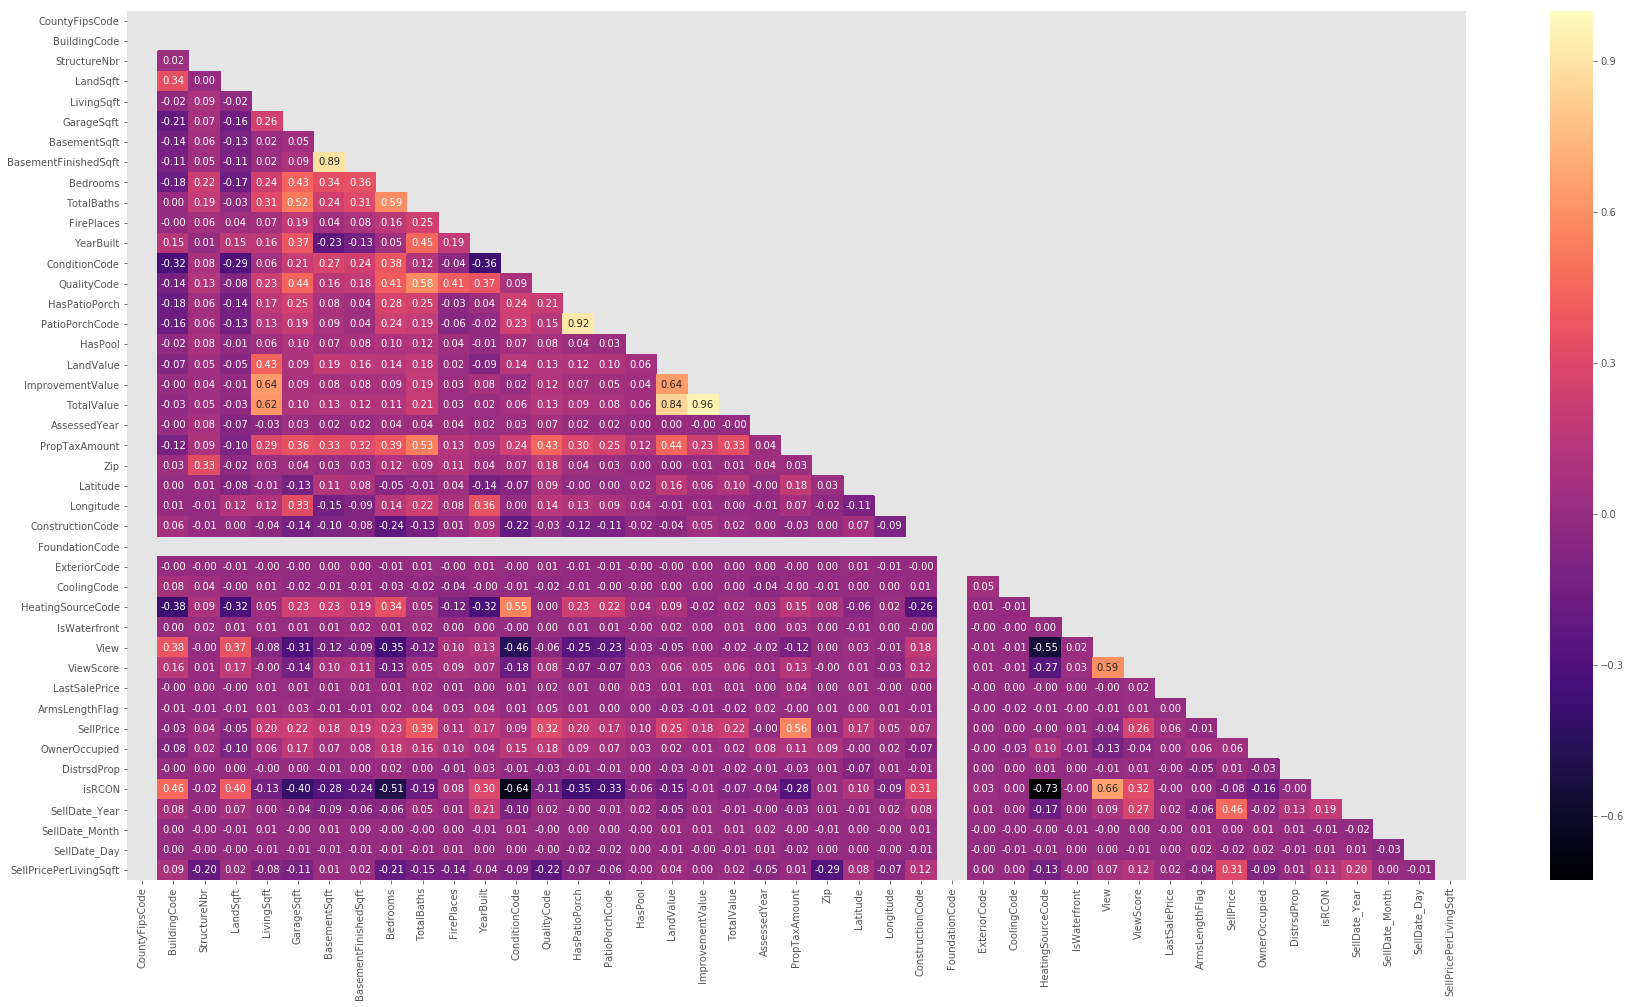

In [15]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 16))
sns.heatmap(df.corr(), annot=True, fmt=".2f", mask=mask, cmap='magma')
plt.show()

In [16]:
relevant_numerical_features = []
for key in corr['isRCON'].keys():
    if abs(corr['isRCON'][key]) > 0.08 and key != 'isRCON':
        relevant_numerical_features.append(key)
relevant_numerical_features

['BuildingCode',
 'LandSqft',
 'LivingSqft',
 'GarageSqft',
 'BasementSqft',
 'BasementFinishedSqft',
 'Bedrooms',
 'TotalBaths',
 'FirePlaces',
 'YearBuilt',
 'ConditionCode',
 'QualityCode',
 'HasPatioPorch',
 'PatioPorchCode',
 'LandValue',
 'PropTaxAmount',
 'Latitude',
 'Longitude',
 'ConstructionCode',
 'HeatingSourceCode',
 'View',
 'ViewScore',
 'SellPrice',
 'OwnerOccupied',
 'SellDate_Year',
 'SellPricePerLivingSqft']

In [17]:
str(len(corr['isRCON']) - len(relevant_numerical_features)) + ' numerical features were removed due to small correlation from a ' \
+ 'total of ' + str(len(corr['isRCON'])) + ' numerical features'

'17 numerical features were removed due to small correlation from a total of 43 numerical features'

Let's take a look on the features that were eliminated.

In [18]:
list(set(corr['isRCON'].keys()).difference(set(relevant_numerical_features))) 

['HasPool',
 'CountyFipsCode',
 'ExteriorCode',
 'SellDate_Month',
 'SellDate_Day',
 'isRCON',
 'IsWaterfront',
 'ArmsLengthFlag',
 'StructureNbr',
 'FoundationCode',
 'DistrsdProp',
 'ImprovementValue',
 'LastSalePrice',
 'Zip',
 'CoolingCode',
 'TotalValue',
 'AssessedYear']

In [19]:
character_type_features = []
types = df.dtypes

for i in range(len(types)):
    if types[i] == object:
        character_type_features.append(list(df)[i])

In [20]:
len(character_type_features)

11

### Correlation between categorical features

For this task **the Chi-square test of independence** is going to be used. Chi-square test of independence **checks if there is a relationship between two nominal variables**. We are considering for instance, two relevant categorical variables: Quality and isRCON, i.e. is going to be tested if the quality of the buildings is higher or lower depending on the real estate type. 

**The H0 (Null Hypothesis)**: _There is no relationship between Quality and variable isRCON_. 

**The H1 (Alternative Hypothesis)**: _There is a relationship between Quality and isRCON_.

If the **p-value is significant** (as close as possible to 0, preferable smaller than 0.05), you can reject the null hypothesis and claim that the findings support the alternative hypothesis.

In [21]:
contingency_table = pd.crosstab(df['Quality'], df['isRCON'])
contingency_table

isRCON       0     1
Quality             
000      250    411 
QAV      23307  8077
QEX      818    89  
QFA      6283   194 
QGO      22035  2362
QLU      1      0   
QPO      120    0

In [22]:
contingency_table, independence_test_results = rp.crosstab(df['Quality'], df['isRCON'], prop='col', test='chi-square')
independence_test_results

Chi-square test    results
0  Pearson Chi-square ( 6.0) =   4445.7996
1  p-value =                     0.0000   
2  Cramer's V =                  0.2637

**Cramér's V** (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables.

In [23]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def get_cramers_v_for_given_features(feature1, feature2):
    confusion_matrix = pd.crosstab(df[feature1], df[feature2]).as_matrix()
    return cramers_v(confusion_matrix)

get_cramers_v_for_given_features('Quality', 'isRCON')

0.26349658266723136

### Analysing Cramer's V values between isRCON and the rest of the nominal predictors

In [24]:
relevant_categorical_features = []
for nominal_feature in character_type_features:
    cramers_v_value = get_cramers_v_for_given_features(nominal_feature, 'isRCON')
    if cramers_v_value > 0.2:
        relevant_categorical_features.append(nominal_feature)
    print(nominal_feature + ' & isRCON Cramer\'s V = ' + str(cramers_v_value))    

Condition & isRCON Cramer's V = 0.8632478584421452
Quality & isRCON Cramer's V = 0.26349658266723136
GarageCarportCode & isRCON Cramer's V = 0.7936183580630225
PoolCode & isRCON Cramer's V = 0.05044388413055082
Zonning & isRCON Cramer's V = 0.8724569994304662
HeatingCode & isRCON Cramer's V = 0.9096367955032864
LastSaleDate & isRCON Cramer's V = 0.18589765625016116
DocType & isRCON Cramer's V = 0.19808772815179745
TransType & isRCON Cramer's V = 0.18763570201821633
DistressCode & isRCON Cramer's V = 0.024183050020849497
StatusDate & isRCON Cramer's V = 0.1981435933573486


The features with a Cramer's V value bigger than 0.2 are going to be kept for the further predictive tasks.

In [25]:
relevant_categorical_features

['Condition', 'Quality', 'GarageCarportCode', 'Zonning', 'HeatingCode']

In [26]:
relevant_features = relevant_numerical_features + relevant_categorical_features
len(relevant_features)

31

In [27]:
df['isRCON'].value_counts()

0    52814
1    11133
Name: isRCON, dtype: int64

Since the number of residential properties is bigger than the number of RCON real estates, it is possible to have some problems caused by the unbalanced dataset but this is going to be discussed, later. 

In [28]:
pd.get_dummies(df[relevant_features]).head()

BuildingCode  LandSqft  LivingSqft  GarageSqft  BasementSqft  BasementFinishedSqft  Bedrooms  TotalBaths  FirePlaces  YearBuilt  ConditionCode  QualityCode  HasPatioPorch  PatioPorchCode  LandValue  PropTaxAmount  Latitude  Longitude  ConstructionCode  HeatingSourceCode  View  ViewScore  SellPrice  OwnerOccupied  SellDate_Year  SellPricePerLivingSqft  Condition_AVE  Condition_FAI  Condition_GOO  Condition_POO  Condition_VGO  Quality_000  Quality_QAV  Quality_QEX  Quality_QFA  Quality_QGO  Quality_QLU  Quality_QPO  GarageCarportCode_  GarageCarportCode_C 0  GarageCarportCode_C 1  GarageCarportCode_C 2  GarageCarportCode_G 0  GarageCarportCode_G 1  GarageCarportCode_G 2  GarageCarportCode_G 3  GarageCarportCode_GA0  GarageCarportCode_GA1  GarageCarportCode_GA2  GarageCarportCode_GB0  GarageCarportCode_GB1  GarageCarportCode_GB2  GarageCarportCode_GB3  GarageCarportCode_GB4  GarageCarportCode_GB6  GarageCarportCode_GD0  Zonning_  Zonning_522  Zonning_A10  Zonning_A10P  Zonning_A10SO  Zonning_A35  Zonning_ABC  Zonning_AG  Zonning_AI1  Zonning_AI2  Zonning_AP  Zonning_B  Zonning_BG  Zonning_BN  Zonning_BO  Zonning_BP  Zonning_BR2  Zonning_BRMO  Zonning_BRR  Zonning_C.C.  Zonning_C1  Zonning_C130  Zonning_C140  Zonning_C165  Zonning_C2  Zonning_C230  Zonning_C240  Zonning_C2P40  Zonning_C3  Zonning_CA  Zonning_CB  Zonning_CBC  Zonning_CBD  Zonning_CBD 1B  Zonning_CBD 2  Zonning_CBD 3  Zonning_CBD 4  Zonning_CBD 6  Zonning_CBD 8  Zonning_CBD-R  Zonning_CBDB  Zonning_CBP  Zonning_CBSO  Zonning_CC  Zonning_CC1  Zonning_CC2  Zonning_CCMU  Zonning_CD  Zonning_CE  Zonning_CF  Zonning_CI  Zonning_CLI  Zonning_CM2  Zonning_CN  Zonning_COR  Zonning_CR  Zonning_CV  Zonning_CZ  Zonning_DC  Zonning_DCE  Zonning_DH255  Zonning_DMC 240290400  Zonning_DMC 340290400  Zonning_DMC160  Zonning_DMC240  Zonning_DMC65  Zonning_DMRC 12565  Zonning_DMRC 240125  Zonning_DMRC 656585  Zonning_DMRC 8565  Zonning_DMRR 12565  Zonning_DMRR 24065  Zonning_DMRR 8565  Zonning_DNTNMU  Zonning_DNTNO1  Zonning_DNTNO2  Zonning_DNTNOB  Zonning_DNTNR  Zonning_DOC1 U450U  Zonning_DOC2 50030050  Zonning_DR  Zonning_DRC 85150  Zonning_DT  Zonning_DUC  Zonning_EH  Zonning_EP  Zonning_EP1  Zonning_EP2  Zonning_F  Zonning_GC  Zonning_GCMU  Zonning_GDC  Zonning_HC  Zonning_HCB  Zonning_HDR  Zonning_HR  Zonning_I  Zonning_IB U45  Zonning_IB U65  Zonning_IDM 7585150  Zonning_IDM7585  Zonning_IDR 45125240  Zonning_IG2 U65  Zonning_IG2 U85  Zonning_JBD 2  Zonning_JBD 5  Zonning_JBD 6  Zonning_L1  Zonning_L2  Zonning_L3  Zonning_LDR  Zonning_LDT  Zonning_LR1  Zonning_LR1 RC  Zonning_LR2  Zonning_LR2 RC  Zonning_LR3  Zonning_LR3 PUD  Zonning_LR3 RC  Zonning_M1  Zonning_M1C  Zonning_M2  Zonning_MB  Zonning_MC  Zonning_MDR  Zonning_MDR8  Zonning_MF2  Zonning_MF2L  Zonning_MF3  Zonning_MFH  Zonning_MFM  Zonning_MHO  Zonning_MIO37LR2  Zonning_MIO37LR3  Zonning_MIO50LR3  Zonning_MIT  Zonning_MPD  Zonning_MR  Zonning_MR85  Zonning_MRD  Zonning_MRG  Zonning_MRH  Zonning_MRM  Zonning_MRRC  Zonning_MRT12  Zonning_MRT16  Zonning_MSC 1  Zonning_MSC 3  Zonning_MU  Zonning_MU12  Zonning_MUO  Zonning_MUR  Zonning_MUR35  Zonning_MUR45  Zonning_MUR70  Zonning_NB  Zonning_NBP  Zonning_NC  Zonning_NC130  Zonning_NC140  Zonning_NC2-65  Zonning_NC230  Zonning_NC240  Zonning_NC265  Zonning_NC2P30  Zonning_NC2P40  Zonning_NC2P65  Zonning_NC340  Zonning_NC365  Zonning_NC385  Zonning_NC3P40  Zonning_NC3P65  Zonning_NC3P85  Zonning_NCBD  Zonning_NRH 3  Zonning_O  Zonning_OMU  Zonning_OP  Zonning_OS2  Zonning_OT  Zonning_P  Zonning_PBZ  Zonning_PLA 15A  Zonning_PLA 15B  Zonning_PLA 16  Zonning_PLA 17  Zonning_PLA 2  Zonning_PLA 3C  Zonning_PLA 5A  Zonning_PLA 5B  Zonning_PLA 5D  Zonning_PLA 5E  Zonning_PLA 6A  Zonning_PLA 6D  Zonning_PLA 6E  Zonning_PLA 6F  Zonning_PLA 6I  Zonning_PLA 6J  Zonning_PLA 6K  Zonning_PLA 7B  Zonning_PMM85  Zonning_PO  Zonning_POSPF  Zonning_PR  Zonning_PR 2.4  Zonning_PRC  Zonning_PRC1  Zonning_PRR  Zonning_PSM 100100120  Zonning_PSM 100100130  Zonning_PSM 100120150  Zonning_PSM100

## Data encoding

In [29]:
encoded_df = pd.get_dummies(df[relevant_features])
encoded_df['isRCON'] = df['isRCON']

In [30]:
corr = encoded_df.corr()
relevant_features_from_encoded_df = []
for key in corr['isRCON'].keys():
    if abs(corr['isRCON'][key]) > 0.08 and key != 'isRCON':
        relevant_features_from_encoded_df.append(key)

In [31]:
len(relevant_features_from_encoded_df)

75

In [32]:
len(list(encoded_df))

479

## Decission Trees classification

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

X_train, X_test, y_train, y_test = train_test_split(encoded_df[relevant_features_from_encoded_df], encoded_df['isRCON'], \
                                                    test_size=0.5, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9928066554075186


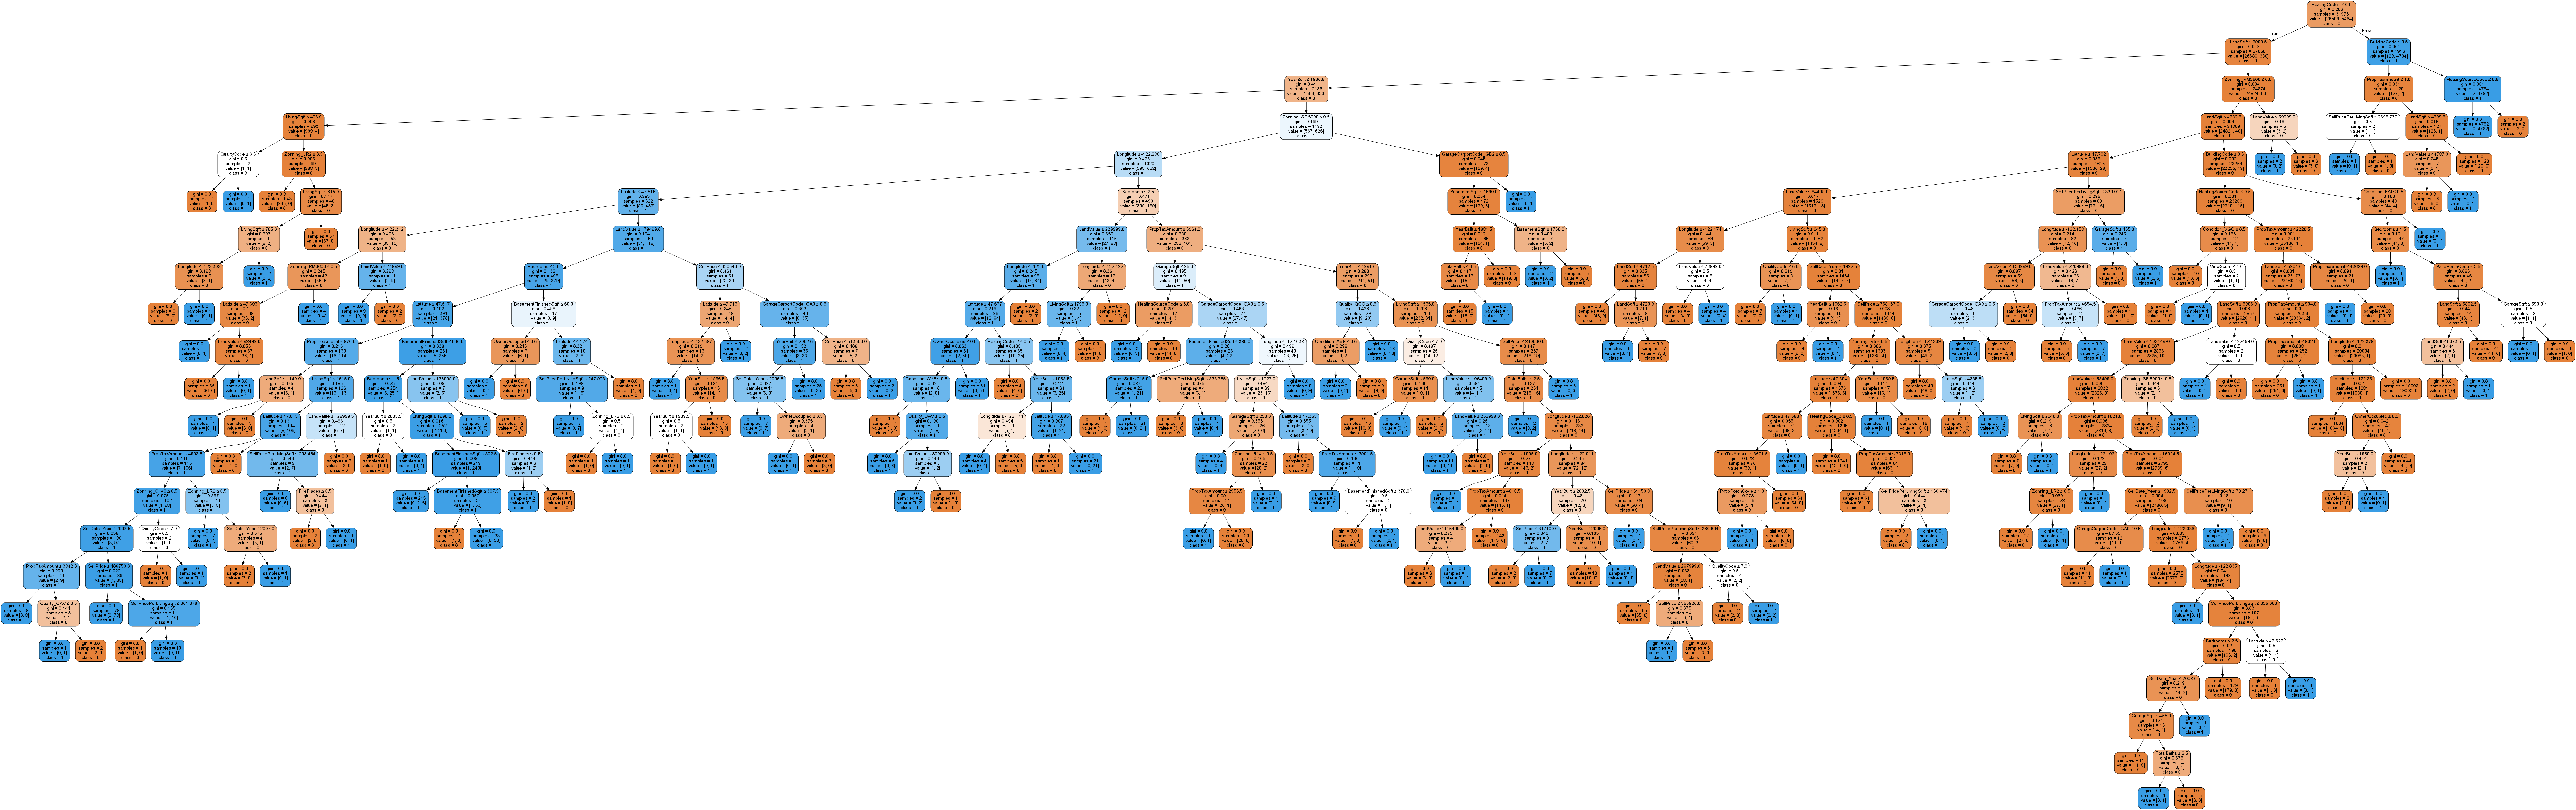

In [34]:
dot_data = StringIO()
export_graphviz(clf, out_file = dot_data,  
                filled=True, rounded = True,
                special_characters = True, feature_names = relevant_features_from_encoded_df,
                class_names=['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('real_estates_dt.png')
Image(graph.create_png())

In [35]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9857384124601238


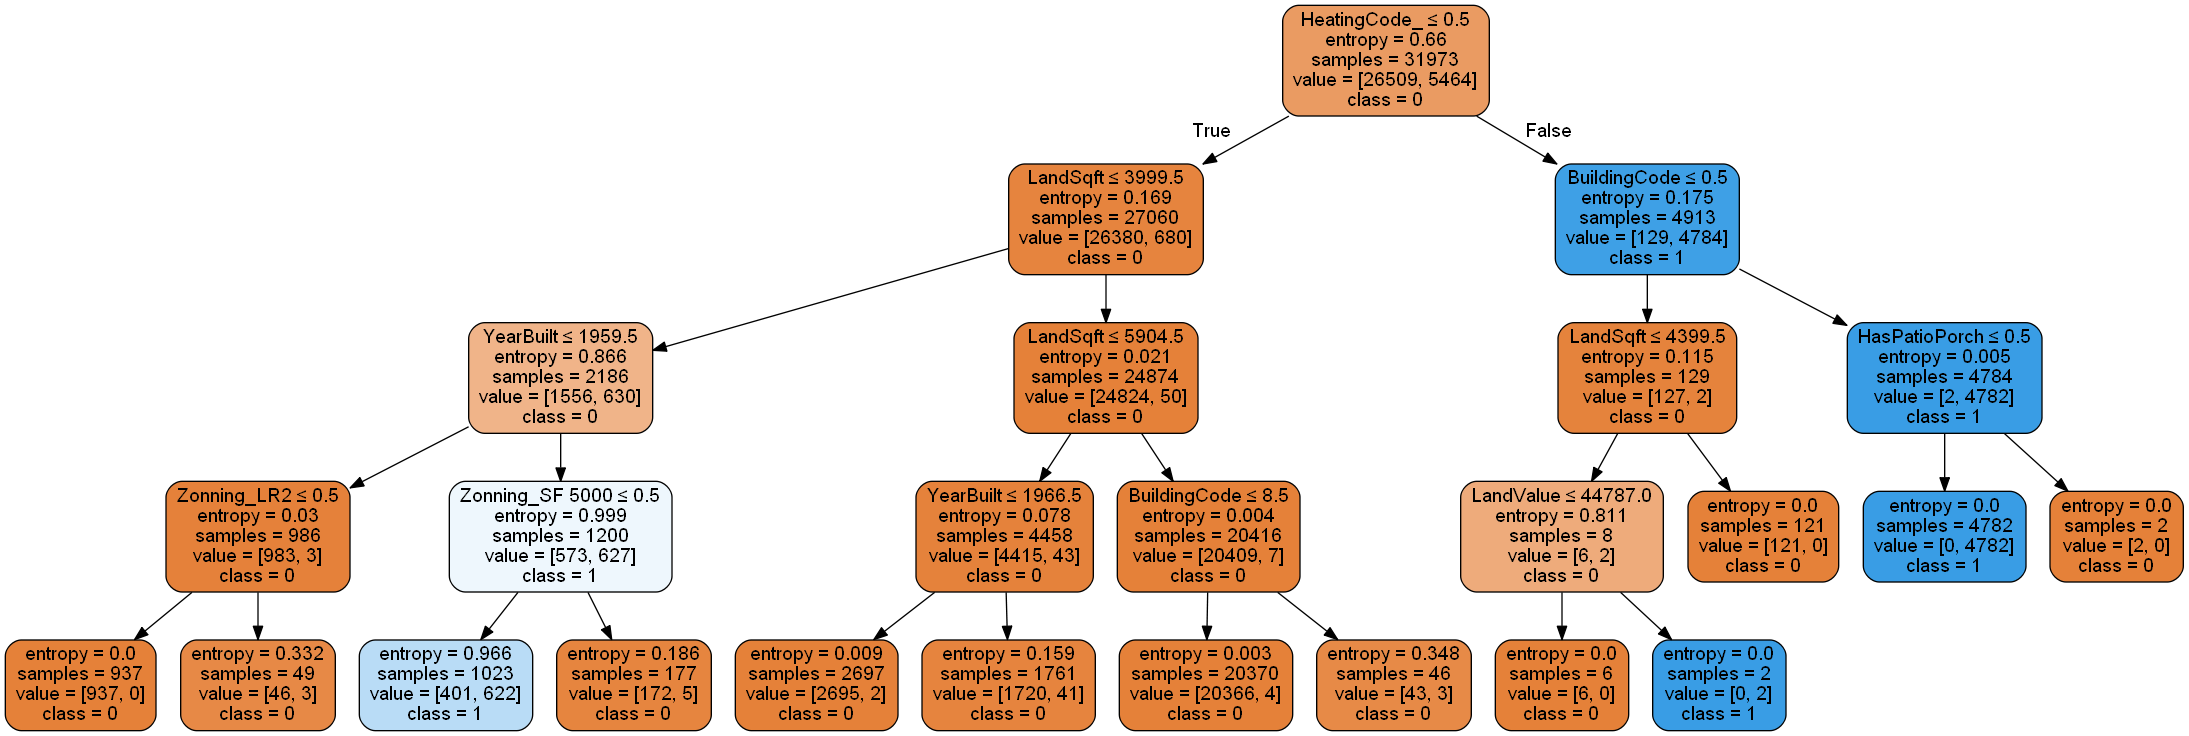

In [36]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = relevant_features_from_encoded_df,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('real_estates_dt_maxdepth3.png')

Image(graph.create_png())

## K Nearest Neighbours

In [40]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9857384124601238


In [41]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[25916   389]
 [   67  5602]]


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26305
           1       0.94      0.99      0.96      5669

    accuracy                           0.99     31974
   macro avg       0.97      0.99      0.98     31974
weighted avg       0.99      0.99      0.99     31974



In [43]:
error_rate = []
# Might take some time
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

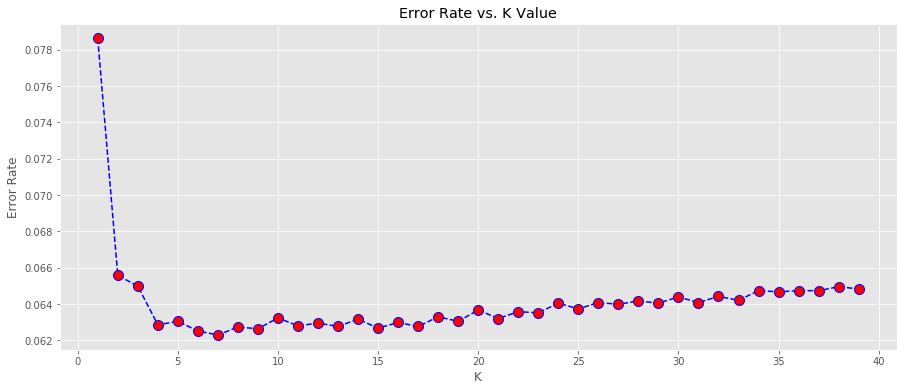

In [45]:
plt.figure(figsize=(15,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [49]:
best_k = np.argmin(error_rate) + 1

### Comparison between 1-NN and tunned k

In [62]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('_____________________   1-NN  _______________________\n')
print('_________________ Confusion Matrix __________________\n\n', confusion_matrix(y_test,pred), '\n')
print('_______________ Classification Report _______________\n\n', classification_report(y_test,pred))

_____________________   1-NN  _______________________

_________________ Confusion Matrix __________________

 [[25193  1112]
 [ 1402  4267]] 

_______________ Classification Report _______________

               precision    recall  f1-score   support

           0       0.95      0.96      0.95     26305
           1       0.79      0.75      0.77      5669

    accuracy                           0.92     31974
   macro avg       0.87      0.86      0.86     31974
weighted avg       0.92      0.92      0.92     31974



In [63]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print('_____________________   7-NN  _______________________\n')
print('_________________ Confusion Matrix __________________\n\n', confusion_matrix(y_test,pred), '\n')
print('_______________ Classification Report _______________\n\n', classification_report(y_test,pred))

_____________________   7-NN  _______________________

_________________ Confusion Matrix __________________

 [[25972   333]
 [ 1659  4010]] 

_______________ Classification Report _______________

               precision    recall  f1-score   support

           0       0.94      0.99      0.96     26305
           1       0.92      0.71      0.80      5669

    accuracy                           0.94     31974
   macro avg       0.93      0.85      0.88     31974
weighted avg       0.94      0.94      0.93     31974



## Gaussian Naive Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9451742040407831


In [76]:
print('______________   Gaussian Naive Bayes _______________\n')
print('_________________ Confusion Matrix __________________\n\n', confusion_matrix(y_test, y_pred), '\n')
print('_______________ Classification Report _______________\n\n', classification_report(y_test, y_pred))

______________   Gaussian Naive Bayes _______________

_________________ Confusion Matrix __________________

 [[25508   797]
 [  956  4713]] 

_______________ Classification Report _______________

               precision    recall  f1-score   support

           0       0.96      0.97      0.97     26305
           1       0.86      0.83      0.84      5669

    accuracy                           0.95     31974
   macro avg       0.91      0.90      0.90     31974
weighted avg       0.94      0.95      0.94     31974



## References

1. **Decission Tree Classification**: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
2. **K Nearest Neighbours** using scikit learn: https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn